# 데이터수집
웹 스크래핑 기법을 통해 원하는 텍스트(리뷰, 뉴스 기사, 소설 등)를 직접 수집   
-구글플레이 리뷰 크롤링  

In [1]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
from bs4 import BeautifulSoup
import time
import random
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [23]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import re
import pandas as pd

# 크롬 드라이버 실행
driver = uc.Chrome()
driver.get("https://play.google.com/store/apps/details?id=com.einnovation.temu&hl=ko")

# 리뷰 창 열기
driver.find_element(By.CSS_SELECTOR, 'c-wiz[jsrenderer="C7s1K"]').find_element(
    By.CSS_SELECTOR, "i.google-material-icons.notranslate.VfPpkd-kBDsod.W7A5Qb"
).click()

In [24]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import re
import pandas as pd

# 스크롤 가능한 div 찾기
scrollable_div = driver.find_element(By.CSS_SELECTOR, 'div.fysCi')

# 수집용 리스트
one_star_reviews = []
five_star_reviews = []
review_text_set = set()

while len(one_star_reviews) < 100 or len(five_star_reviews) < 100:
    reviews = driver.find_elements(By.CSS_SELECTOR, 'div.RHo1pe')

    for review in reviews:
        try:
            rating_element = review.find_element(By.CSS_SELECTOR, 'div[role="img"]')
            rating_text = rating_element.get_attribute("aria-label")

            rating_match = re.search(r"(\d+)개 만점에 (\d+)개", rating_text)
            if rating_match:
                stars_received = int(rating_match.group(2))

                # 1점 또는 5점만 수집 (조건 미달 시만)
                if (stars_received == 1 and len(one_star_reviews) < 100) or \
                   (stars_received == 5 and len(five_star_reviews) < 100):

                    review_text = review.text.strip()
                    if review_text in review_text_set:
                        continue  # 중복 제거

                    review_text_set.add(review_text)

                    # 이름 추출
                    try:
                        name_element = review.find_element(By.CSS_SELECTOR, 'span.X5PpBb')
                        name = name_element.text.strip()
                    except:
                        name = "Unknown"

                    # 텍스트 정제
                    cleaned_review_text = review_text.replace('more_vert', '').replace(name, '').strip()

                    # 저장
                    row = [name, stars_received, cleaned_review_text]

                    if stars_received == 1:
                        one_star_reviews.append(row)
                    else:
                        five_star_reviews.append(row)

                    # 종료 조건
                    if len(one_star_reviews) >= 100 and len(five_star_reviews) >= 100:
                        break

        except Exception as e:
            print("❌ 오류 발생:", e)

    driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scrollable_div)
    time.sleep(2)

# 데이터프레임 생성 및 저장
collected_reviews = one_star_reviews + five_star_reviews
df = pd.DataFrame(collected_reviews, columns=["이름", "별점", "리뷰"])
df["리뷰"] = df["리뷰"].apply(lambda x: x.replace('\n', ' ').strip())

df.to_csv("테무 리뷰 크롤링.csv", index=False, encoding="utf-8-sig")
print("✅ 수집 완료! 1점:", len(one_star_reviews), "5점:", len(five_star_reviews))

✅ 수집 완료! 1점: 100 5점: 100


In [28]:
import re

def clean_review(text):
    # "이름 YYYY년 MM월 DD일" 제거
    return re.sub(r'^.*?\d{4}년 \d{1,2}월 \d{1,2}일\s*', '', text)

df['리뷰'] = df['리뷰'].apply(clean_review)
df

,이름,별점,리뷰
0,Unknown,1,다운순간 미끼에 걸린겁니다. 광고처럼 0원준다해놓고 다운하면 얼마를 사야준다?구매하...
1,Unknown,1,"장점 - 배송만 대체적으로 빠르다. 단점 - 제품구매시 쿠폰을 주네, 그레딧을 주네..."
2,Unknown,1,"그냥 사기입니다. 모든 게 최악이고, 모든 게 엉망입니다. 진심으로 단 한개의 물건..."
3,Unknown,1,테무는사기꾼집단입니다.그림은좋은상품으로포장해현혹시켜서진짜저렴한가격에당첨된것처럼위장해...
4,Unknown,1,좋긴 좋은데 적당히 광고 하고 무료선물 준다고 게임이니 식물키우기니 물고기 키우기니...
...,...,...,...
195,Unknown,5,"날이갈수록 "" 테무"" 물건도 품질이 더욱 좋아지고있고 배송도 빨라져서 주문하기도 편..."
196,Unknown,5,태무 처음 으로 구매 했는데 다 만족했습니다!앞으로도 좋은 물건 많이 만들어 주시고...
197,Unknown,5,가격은 다른곳보다 마니 저렴해요 생각보다 배송도 빠른것 같아요 다양한 쿠폰들도 많아...
198,Unknown,5,독특하고 합리적인 가격의 패션 의상을 선택할수 있어요


In [30]:
df.to_csv("테무 리뷰 크롤링_수정.csv", index=False, encoding="utf-8-sig")

# 드라이버 종료
driver.quit()

# 데이터 전처리
수집한 텍스트를 정제하고, 토큰화(tokenization)·패딩(padding)·정수 인코딩 등 시계열 딥러닝 입력 형식에 맞게 전처리

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler       # 특성이 3개니까 표준화도 필요
import pandas as pd

df = pd.read_csv("Data/테무 리뷰 크롤링_수정.csv")
del df["별점"]
df
# 부정적리뷰는 0, 긍정적리뷰는 1

,리뷰,label
0,다운순간 미끼에 걸린겁니다. 광고처럼 0원준다해놓고 다운하면 얼마를 사야준다?구매하...,0
1,"장점 - 배송만 대체적으로 빠르다. 단점 - 제품구매시 쿠폰을 주네, 그레딧을 주네...",0
2,"그냥 사기입니다. 모든 게 최악이고, 모든 게 엉망입니다. 진심으로 단 한개의 물건...",0
3,테무는사기꾼집단입니다.그림은좋은상품으로포장해현혹시켜서진짜저렴한가격에당첨된것처럼위장해...,0
4,좋긴 좋은데 적당히 광고 하고 무료선물 준다고 게임이니 식물키우기니 물고기 키우기니...,0
...,...,...
195,"날이갈수록 "" 테무"" 물건도 품질이 더욱 좋아지고있고 배송도 빨라져서 주문하기도 편...",1
196,태무 처음 으로 구매 했는데 다 만족했습니다!앞으로도 좋은 물건 많이 만들어 주시고...,1
197,가격은 다른곳보다 마니 저렴해요 생각보다 배송도 빠른것 같아요 다양한 쿠폰들도 많아...,1
198,독특하고 합리적인 가격의 패션 의상을 선택할수 있어요,1


In [37]:
train_x, test_x, train_y, test_y = train_test_split(df["리뷰"],
                                                    df["label"])        # 훈련데이터:시험데이터가 75:25로 쪼개짐

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer       # 텍스트를 토큰화해서 잘게 쪼개줌

# 사용할 단어 개수 (가장 많이 사용된 단어 순으로 1등~1000등까지 사용한다)
vocab_size = 1000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_x)         # 텍스트를 토큰화

In [39]:
tokenizer.word_index           # 각 토큰에 인덱스 부여
# 이 안에 없는 새로운 단어는 1로

{'<OOV>': 1,
 '이': 2,
 '수': 3,
 '다': 4,
 '너무': 5,
 '사용자': 6,
 '무료로': 7,
 '리뷰가': 8,
 '상품': 9,
 '광고': 10,
 '유용하다고': 11,
 '평가함': 12,
 '그냥': 13,
 '잘': 14,
 '가격이': 15,
 '물건을': 16,
 '더': 17,
 '좀': 18,
 '많이': 19,
 '제품': 20,
 '배송도': 21,
 '다른': 22,
 '물건': 23,
 '좋은': 24,
 '테무': 25,
 '제품이': 26,
 '그리고': 27,
 '완전': 28,
 '할': 29,
 '1': 30,
 '절대': 31,
 '또': 32,
 '테무에서': 33,
 '마세요': 34,
 '제품을': 35,
 '했는데': 36,
 '100': 37,
 '저는': 38,
 '구매': 39,
 '합니다': 40,
 '조금': 41,
 '가격에': 42,
 '것': 43,
 '아주': 44,
 '가격도': 45,
 '있습니다': 46,
 '좋아요': 47,
 '상품을': 48,
 '상품도': 49,
 '정도': 50,
 '있지만': 51,
 '하고': 52,
 '수가': 53,
 '같아요': 54,
 '자주': 55,
 '준다고': 56,
 '안': 57,
 '앱': 58,
 '99': 59,
 '2': 60,
 '좋고': 61,
 '광고는': 62,
 '그': 63,
 '결제': 64,
 '가격대비': 65,
 '있어서': 66,
 '진짜': 67,
 '좋습니다': 68,
 '매우': 69,
 '아니고': 70,
 '거': 71,
 '보고': 72,
 '한': 73,
 '꼭': 74,
 '같은': 75,
 '거의': 76,
 '다양한': 77,
 '제품은': 78,
 '없습니다': 79,
 '있는': 80,
 '엄청': 81,
 '바로': 82,
 '0': 83,
 '3': 84,
 '만족합니다': 85,
 '없는': 86,
 '계속': 87,
 '장바구니에': 88,
 '반품': 89,


In [40]:
train_seq = tokenizer.texts_to_sequences(train_x)       # 텍스트데이터를 숫자로
test_seq = tokenizer.texts_to_sequences(test_x)

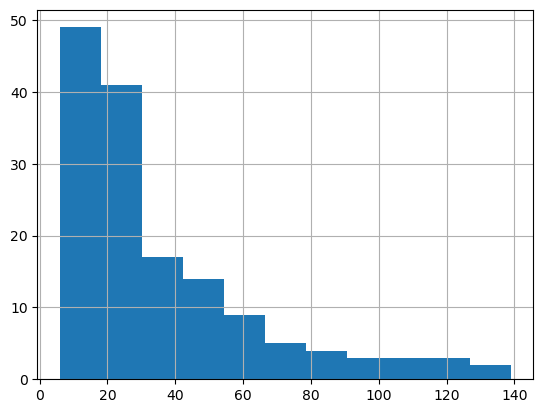

In [42]:
import matplotlib.pyplot as plt

box = []
for i in train_seq:
    box.append(len(i))       # 각 사람이 리뷰에 사용한 단어의 개수

plt.hist(box, bins = "auto")
plt.grid()
plt.show()

In [125]:
from keras.preprocessing.sequence import pad_sequences

# train_seq2 = pad_sequences(train_seq, 100, padding="pre", truncating="pre")  
# test_seq2 = pad_sequences(test_seq, 100, padding="pre", truncating="pre")  
train_seq2 = pad_sequences(train_seq, 100)  
test_seq2 = pad_sequences(test_seq, 100)  

# 모델 설계·훈련
RNN 또는 LSTM 계열 네트워크를 설계하고, 긍정/부정(혹은 기타 두 개 이상의 클래스) 분류 모델 학습

In [126]:
from tensorflow import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from keras.layers import Embedding
from keras.layers import SimpleRNN, LSTM

cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
cw_dict = dict(enumerate(cw))

model = keras.Sequential([
    Input(shape=(100,)),
    Embedding(input_dim=1000, output_dim=32),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 100, 32)             │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,978 (230.38 KB)

 Trainable params: 58,978 (230.38 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
import numpy as np

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(train_seq2, train_y, epochs = 1000,
                    validation_data=(test_seq2, test_y),
                    class_weight=cw_dict,
                    callbacks = [es])

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5295 - loss: 0.6952 - val_accuracy: 0.4800 - val_loss: 0.6925
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7519 - loss: 0.6803 - val_accuracy: 0.5600 - val_loss: 0.6875
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7165 - loss: 0.6666 - val_accuracy: 0.6400 - val_loss: 0.6601
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6234 - loss: 0.6467 - val_accuracy: 0.5600 - val_loss: 0.7047
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7265 - loss: 0.6102 - val_accuracy: 0.5600 - val_loss: 0.7266
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7283 - loss: 0.6069 - val_accuracy: 0.5600 - val_loss: 0.7338
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7607 - loss: 0.5303 - val_accuracy: 0.5200 - val_loss: 0.7934
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8395 - loss: 0.4605 - val_accuracy: 0.5600 - v

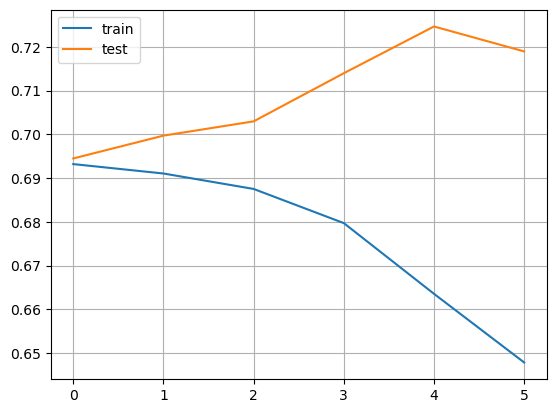

In [128]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])       # 에폭이 하나 끝날때마다 쳤던 시험데이터의 쪽지시험 
plt.legend(["train", "test"])
plt.grid()
plt.show()

# 성능 평가
적절한 지표(정확도, F1-score, AUC 등)를 활용하여 모델 성능을 정량적으로 평가

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
✅ 정확도: 0.6400
✅ F1-score: 0.7353
✅ AUC: 0.5823

              precision    recall  f1-score   support

           0       0.54      0.37      0.44        19
           1       0.68      0.81      0.74        31

    accuracy                           0.64        50
   macro avg       0.61      0.59      0.59        50
weighted avg       0.62      0.64      0.62        50



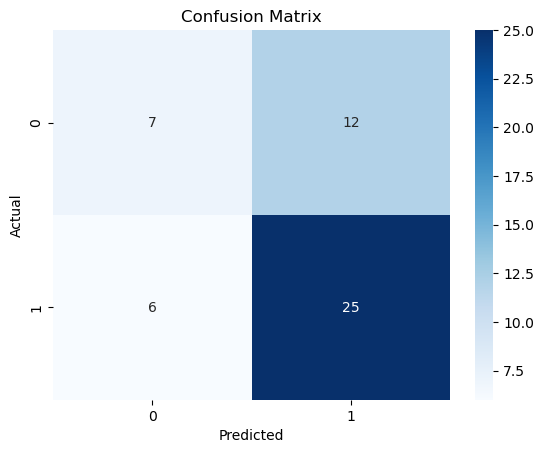

In [130]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns

# 예측
pred_prob = model.predict(test_seq2)
pred = pred_prob.argmax(axis=1)

acc = accuracy_score(test_y, pred)
f1 = f1_score(test_y, pred)
auc = roc_auc_score(test_y, pred_prob[:, 1])

print(f"✅ 정확도: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")
print(f"✅ AUC: {auc:.4f}")
print()
print(classification_report(test_y, pred))

# ✅ 11. 혼동 행렬 시각화
cm = confusion_matrix(test_y, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [131]:
from sklearn.metrics import classification_report, confusion_matrix

pred_prob = model.predict(test_seq2)
pred = pred_prob.argmax(axis=1)

print(classification_report(test_y, pred, digits=4))
print(confusion_matrix(test_y, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0     0.5385    0.3684    0.4375        19
           1     0.6757    0.8065    0.7353        31

    accuracy                         0.6400        50
   macro avg     0.6071    0.5874    0.5864        50
weighted avg     0.6235    0.6400    0.6221        50

[[ 7 12]
 [ 6 25]]


In [132]:
text = ["배송이 느려요"]

A = tokenizer.texts_to_sequences(text)     # 텍스트 토큰화
A = pad_sequences(A, 100)

model.predict(A)

# 부정적일 확률이 99.9%, 긍정적일 확률이 0.1%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.29956874, 0.7004313 ]], dtype=float32)